In [39]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [6]:
p_ft = 300 * 100
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
# ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
# ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

In [8]:
# Only include Daily average contribution if using 500hPa pressure level
# ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(
#     dim='time')
# if p_ft != 500 * 100:
#     ds['T500_zonal_daily_av_resize'] = ds['T500_zonal_daily_av_resize'] * 0
#     ds['T500_zonal_daily_av'] = ds['T500_zonal_daily_av'] * 0

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

In [9]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))
# Get z LCL at the approx same pressure as LCL
ds['z_lcl'] = interp_var_at_pressure(ds.Z3, ds.p_lcl, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0)).Z3

In [246]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_pot_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)
    temp_pot_start = potential_temp(temp_start, p_start)
    mask = (temp_pot_env - temp_pot_start) > temp_pot_thresh
    # Find highest level where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(temp_env.lev.size)).max(dim='lev') + 1).astype(int)

    # Find level in between model levels where diff of pot temp from the surface is exactly temp_thresh
    # Assume fixed lapse rate in log pressure coords between adjacent model levels
    p_low = np.log10(p_env.isel(lev=lcl_ind))             # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind-1))          # further from surface

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind-1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_start + temp_pot_thresh
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_lcl = 10**p_target
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)

def find_lcl_empirical2(temp_env, p_env, z_env, temp_start=None, p_start=None, temp_pot_thresh=2, temp_pot_thresh_lapse=0.5, lapse_thresh=8.5):
    # Find the lowest model layer with lapse rate less than lapse_thresh
    # LCL is the level at which the pot temp drops by 0.5K within this layer
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)

    # First mask is pot temp close to surface pot temperature
    temp_pot_start = potential_temp(temp_start, p_start)
    mask_temp = np.abs(temp_pot_env - temp_pot_start) <= temp_pot_thresh

    # Second mask is lapse rate close to dry adiabat
    # lower is so append high value at surface
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)        # make same shape
    lapse = lapse.fillna(lapse_thresh+5)        # ensure final value satisfies lapse criteria
    mask_lapse = lapse > lapse_thresh
    mask = (mask_temp & mask_lapse)
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).min(dim='lev')).astype(int)


    p_low = np.log10(p_env.isel(lev=lcl_ind))             # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind-1))          # further from surface

    # print(p_low)
    # print(p_high)
    # print(np.log10(p_env))

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind-1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_low + temp_pot_thresh_lapse
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_target = p_target.clip(min=p_high)
    p_lcl = 10**p_target
    # print(dry_profile_temp(temp_start, p_start, p_lcl))
    # print(lapse.isel(lev=lcl_ind-1))
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)

ds['p_lcl_emp'], ds['T_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)
ds['p_lcl_emp2'], ds['T_lcl_emp2'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3)

In [137]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

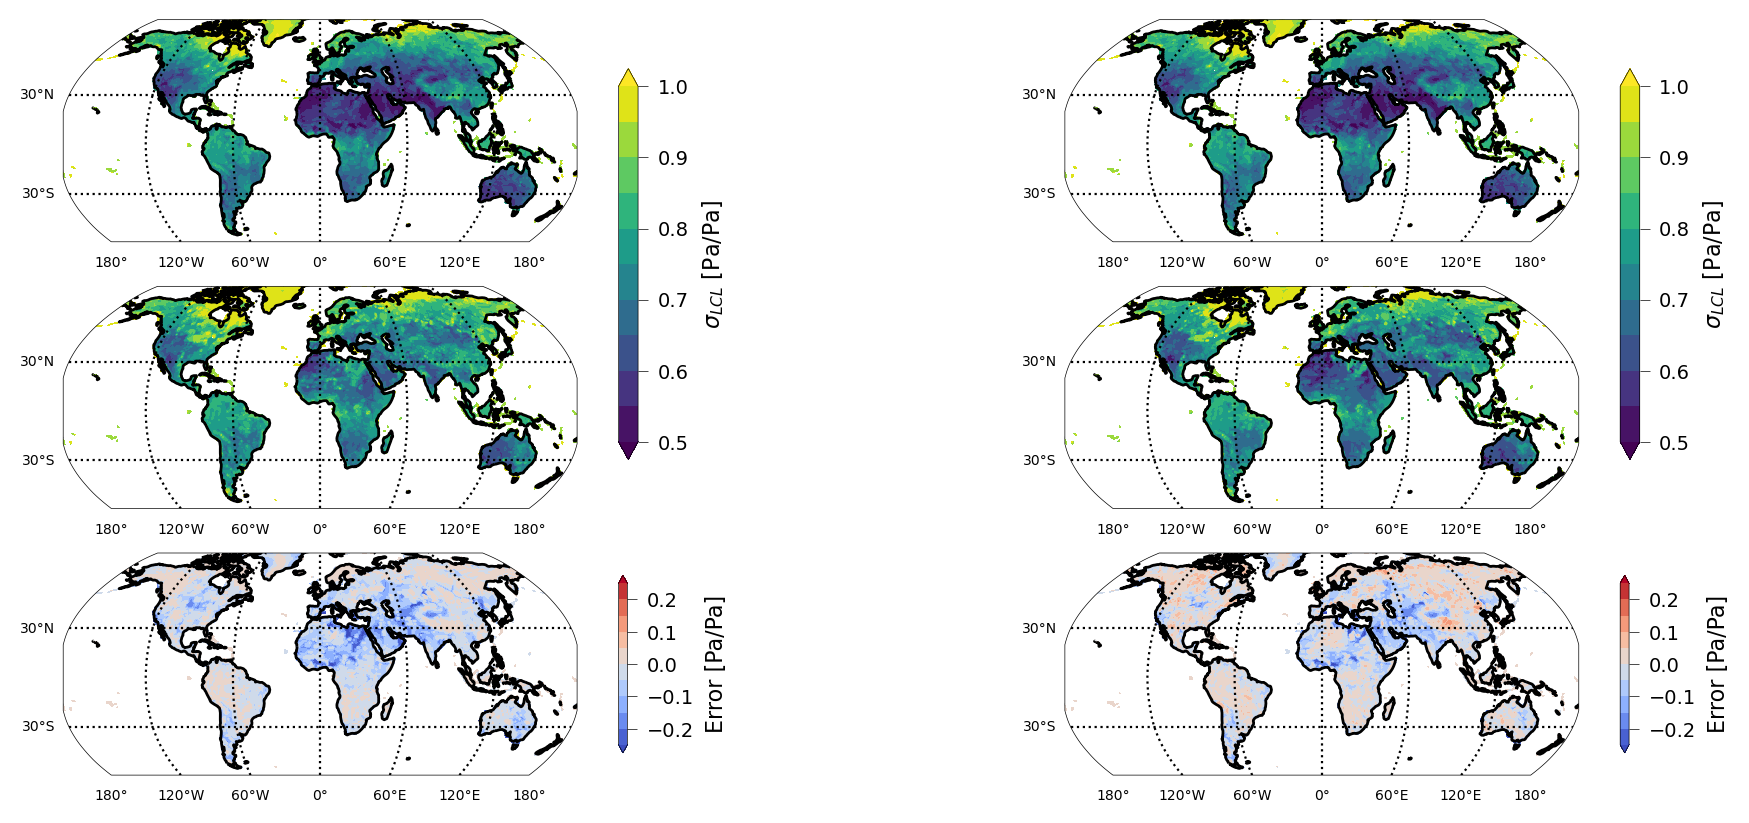

In [252]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
for ax_use in ax.flatten():
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 0], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 0], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 0], label='Error [Pa/Pa]', mappable=im)

plot_contour_projection(ax[0, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 1], (ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 1], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 1], label='Error [Pa/Pa]', mappable=im)

# ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time of year\nPhysical')
# ax[1].set_title('Empirical')
# ax[2].set_title('Physical - Empirical')
# isca_tools.savefig(fig)
plt.show()

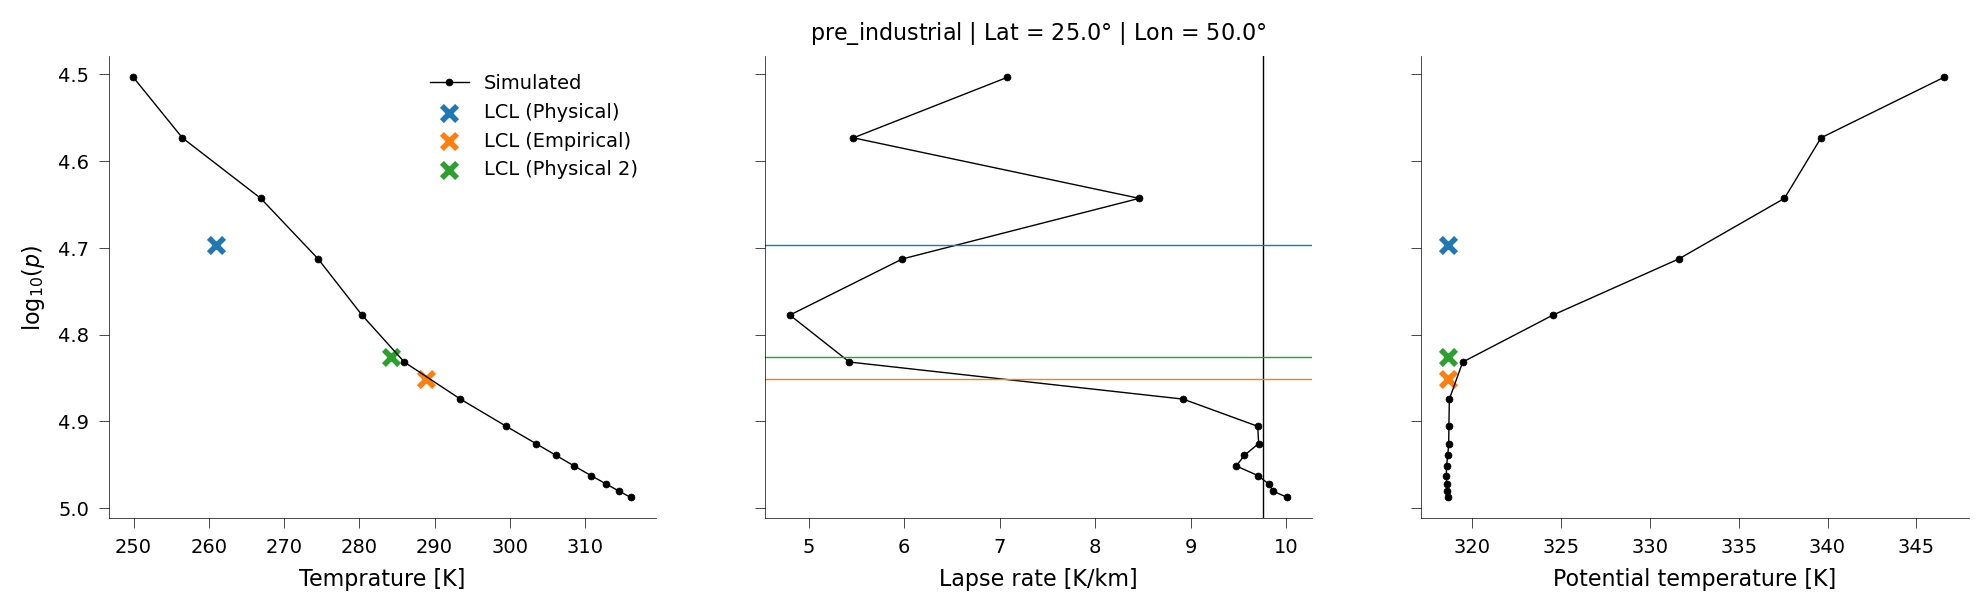

In [253]:
ds_use = ds.isel(co2=0).sel(lat=-15, lon=320,method='nearest')      # Amazon 1
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300,method='nearest')    # Amazon 2
# ds_use = ds.isel(co2=1).sel(lat=3, lon=15, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=3, lon=20, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=50, lon=25, method='nearest')        # Europe
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')        # Canada
# ds_use = ds.isel(co2=1).sel(lat=35, lon=100, method='nearest')        # Tibet
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
# ds_use = ds.isel(co2=0).sel(lat=20, lon=0,method='nearest')      # Sahara
ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')      # Pursian Gulf
ds_use['lapse_rate'] =  -ds_use.T.diff(dim='lev', label='upper') / ds_use.Z3.diff(dim='lev', label='upper') * 1000

fig, ax = plt.subplots(1, 3, sharey=True)
fig_resize(fig, 12)
ax[0].plot(ds_use.T.where(ds_use.P>30000), np.log10(ds_use.P).where(ds_use.P>30000), marker='o', color='k', label='Simulated')

x_var = ds_use['lapse_rate'].where(ds_use.P.isel(lev=slice(1, 999999))>30000)
y_var = np.log10(ds_use.P).isel(lev=slice(1, 999999)).where(ds_use.P.isel(lev=slice(1, 999999))>30000)
ax[1].plot(x_var, y_var, marker='o', color='k')
ax[1].axvline(lapse_dry*1000, color='k')

ds_use['T_pot'] = potential_temp(ds_use.T, ds_use.P)
ax[2].plot(ds_use.T_pot.where(ds_use.P>30000), np.log10(ds_use.P).where(ds_use.P>30000), marker='o', color='k', label='Simulated')

# Add LCL info
var = find_lcl_empirical2(ds_use.T, ds_use.P, ds_use.Z3)
var = find_lcl_empirical(ds_use.T, ds_use.P)
ax[0].scatter(ds_use.T_lcl, np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', label='LCL (Physical)')
ax[0].scatter(ds_use.T_lcl_emp, np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', label='LCL (Empirical)')
ax[0].scatter(ds_use.T_lcl_emp2, np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2', label='LCL (Physical 2)')
ax[1].axhline(np.log10(ds_use.p_lcl), color='C0')
ax[1].axhline(np.log10(ds_use.p_lcl_emp), color='C1')
ax[1].axhline(np.log10(ds_use.p_lcl_emp2), color='C2')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2')

ax[0].invert_yaxis()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temprature [K]')
ax[1].set_xlabel('Lapse rate [K/km]')
ax[2].set_xlabel('Potential temperature [K]')
ax[0].legend()
ax[1].set_title(f"{exp_name[int(ds_use.co2)-1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$")
plt.show()